### Setup

In [1]:
# Import regular packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import itertools
from datetime import datetime
from astropy.time import Time
import os
from scipy.signal import find_peaks

In [2]:
# Choose what to load
checkpoint_num = 63000

# Load in checkpoint
ckpt_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/representative_samples/1in25_targets_ckpts/"
filename = f"1in25_targets_ckpt{checkpoint_num}.npy"
ckpt_file = ckpt_dir + filename
checkpoint = np.load(ckpt_file, allow_pickle=True)
all_snrs = checkpoint[:, 0]
all_signals = checkpoint[:, 1]

# Load in data
data_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/representative_samples/"
filename = "1in25_targets.csv"
data_file = data_dir + filename
df = pd.read_csv(data_file)

# Put things together
df["antenna_snrs"] = all_snrs
df["antenna_signals"] = all_signals

# Reduce down to what we have data for
df = df.iloc[:checkpoint_num+1]
assert(len(df.iloc[-1].antenna_snrs) > 0)
assert(len(df.iloc[-1].antenna_signals) > 0)

#### Double check data

In [3]:
# Figure out how far it got
# Figure out what number to start at
def find_first_none(array):
    for i, item in enumerate(array):
        if type(item) == type(None):
            return i

first_none_snrs = find_first_none(all_snrs)
first_none_signals = find_first_none(all_signals)
assert(all_snrs[first_none_snrs] == None)
assert(all_signals[first_none_signals] == None)
assert(first_none_snrs == first_none_signals)
first_none = first_none_snrs
print(first_none)
print(f"The checkpoint is from 63000, so it makes sense that everything after that isn't assigned yet (None)")
last_good = first_none - 1

63001
The checkpoint is from 63000, so it makes sense that everything after that isn't assigned yet (None)


In [4]:
# So a better question is how many are [] (rows that couldn't find stamps)
# and why that's the case
snrs_are_empty = np.array([type(entry) == type([]) for entry in all_snrs[:first_none]])
signals_are_empty = np.array([type(entry) == type([]) for entry in all_signals[:first_none]])
assert(np.array_equal(snrs_are_empty, signals_are_empty)) # So if one is empty the other is empty as expected
num_entries = len(snrs_are_empty)
num_empty = sum(snrs_are_empty)
num_full =  num_entries - num_empty
print(f"Of {num_entries} run antenna signals, {num_empty} entries are [] (leaving {num_full} actual values, {round(num_full / num_entries * 100, 3)}%)")

Of 63001 run antenna signals, 0 entries are [] (leaving 63001 actual values, 100.0%)


### Analysis

So we have, for each hit, a list of antenna powers and antenna snrs. We could go through each of those and look for the SARFI spikes in signal at a single antenna. That's what the code below will do. However, what we don't have is a map from the index of the antenna back to the 'ea' number. That code can be found in find_high_antenna_power_stamp.ipynb and needs access to the stamp files again. We also don't have the index from hit to stamp (which .stamp file and what 'frame' or index of stamp in the stamp file that hit corresponds to). We also didn't get through that many of the 1.2M 1in25 hits we had planned to. Luckily, Dave MacMahon is building that index right now. So hopefully with that index, we can go back in and (in Julia or with multiprocessing) do the calculation of antenna signal and snr for each antenna as well as pull out what the 'ea' numbers (titles) for each antenna are so when we find SARFI we can link it back to a physical dish

#### Algorithm 1 - threshold on max signal

In [15]:
# Returns a list of anomalous antennas or an empty list if none are found
# antenna_signals is (num_antennas, 1) array of the strength of the signal in the antenna
# antenna_snrs is a (num_anennas, 1) array of the snr of the signal in the antenna
# Threshold is how much stronger the max signal has to be than the next highest signal 
# to be an anomalous antenna
# snr_threshold will make it so antennas less than the snr threshold aren't considered for the max signal
# n_anomalous_antennas is the number of anomalous antennas to look for. If it's greater than 1, it's the
# number of antennas which can be above the threshold before it's not an anomalous signal
def find_anomalous_antenna(antenna_signals, antenna_snrs, threshold, snr_threshold=None, n_anomalous_antennas=1):
    assert(threshold >= 1) # Threshold only makes sense if it's 1 or greater
    assert(snr_threshold == None or isinstance(snr_threshold, (int, float))) # snr should be None or an int or a float
    assert(len(antenna_signals > 0))
    assert(len(antenna_snrs > 0))
    assert(n_anomalous_antennas >= 1 and n_anomalous_antennas < 27) # Look for [1, n_antennas - 1] anomalous antennas

    # Check the snr constraint if there is one
    if (snr_threshold != None):
        candidates_for_max = (antenna_snrs >= snr_threshold)
        # Check if there's nothing we'd call a signal
        if candidates_for_max.sum() < 1:
            return []
        
        # Get the maximum signal
        index_of_max_in_candidates = antenna_signals[candidates_for_max].argmax() # Which of the candidates is the max
        original_indices = np.where(candidates_for_max)[0] # Indices of signals array
        index_of_max = original_indices[index_of_max_in_candidates] # Which index from the signals array was the max
    else:
        index_of_max = antenna_signals.argmax()
    
    # Check how many signals are threshold times larger than the maximum
    maximum = antenna_signals[index_of_max]
    indices_above_threshold = np.where(antenna_signals * threshold > maximum)[0]
    number_above_threshold = len(indices_above_threshold) # At least 1 because maximum * threshold > maximum (threshold >= 1)

    # If we see anomalies in the number of anomalous antennas we're looking for or fewer
    # (ie looking for 3 or fewer anomalous antennas and we see anomalously high signals
    # in two antennas) then deem it anomalous RFI, otherwise it's a normal signal which
    # was detected in multiple antennas
    if number_above_threshold <= n_anomalous_antennas:
        return indices_above_threshold
    else:
        return []

In [77]:
# Go in and get the anomalous antennas out
all_anomalous_antennas = np.full_like(df.id, None, dtype="object")
threshold = 5
for i, row in df.iterrows():
    all_anomalous_antennas[i] = find_anomalous_antenna(row.antenna_signals, row.antenna_snrs, threshold, snr_threshold=2, n_anomalous_antennas=10)

# Save anomalous antennas
df["anomalous_antennas"] = all_anomalous_antennas

# Calculate number of them and save that too
num_anomalous_antennas = [len(antennas) for antennas in all_anomalous_antennas]
df["num_anomalous_antennas"] = num_anomalous_antennas

Text(0, 0.5, 'Count of Hits with That Many Anomalous Antennas')

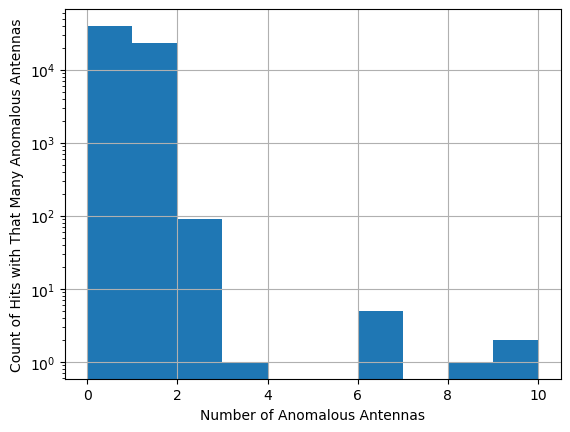

In [78]:
# Look at count of how many anomalous antennas are seen
# Expect to see mostly SARFI (single antenna)
df.num_anomalous_antennas.hist(bins=10)
plt.yscale('log')
plt.xlabel("Number of Anomalous Antennas")
plt.ylabel("Count of Hits with That Many Anomalous Antennas")

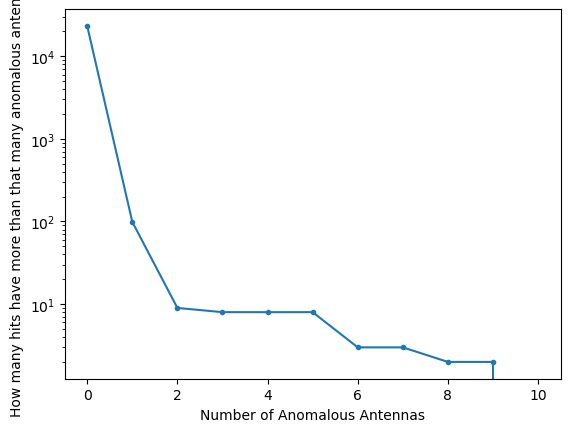

In [79]:
xaxis = range(11)
plt.plot(xaxis, [(df.num_anomalous_antennas > i).sum() for i in xaxis], marker='.')
plt.xlabel("Number of Anomalous Antennas")
plt.ylabel("How many hits have more than that many anomalous antennas")
plt.yscale('log')

In [80]:
weird_ones = df[df.num_anomalous_antennas > 3]
print(len(weird_ones))

8


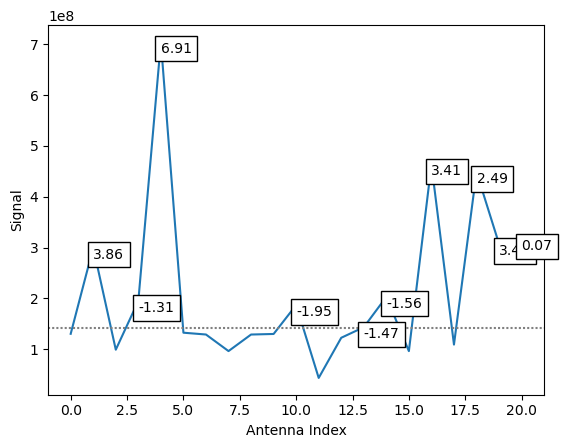

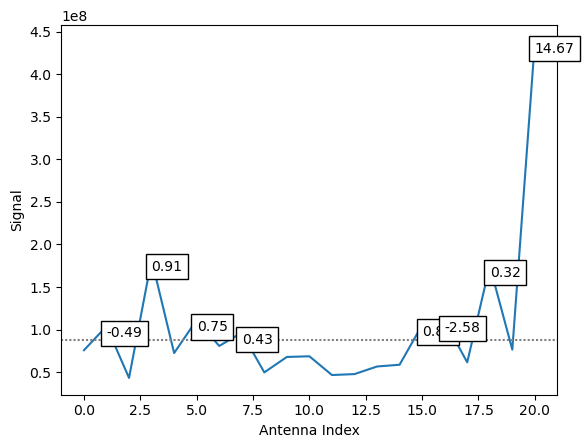

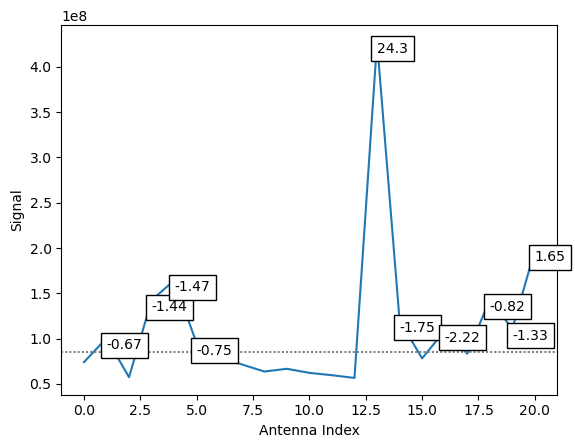

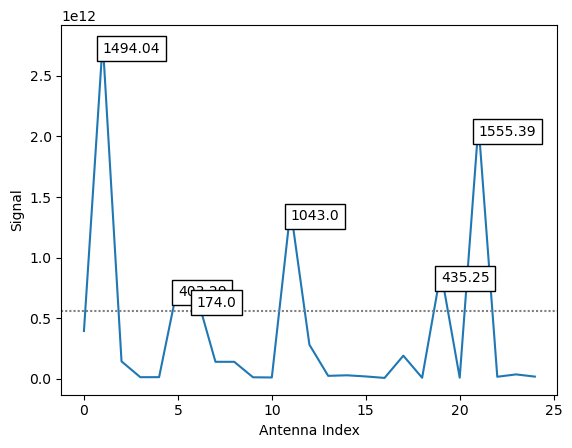

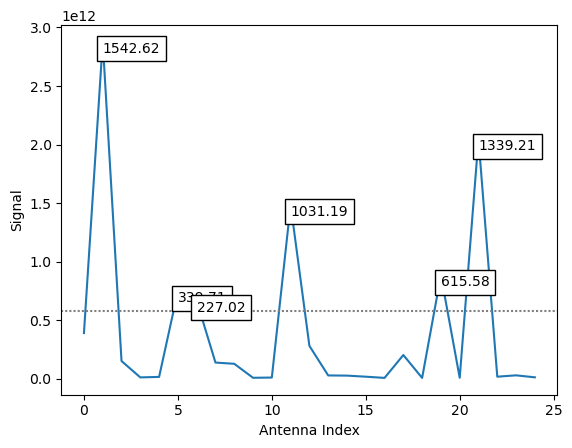

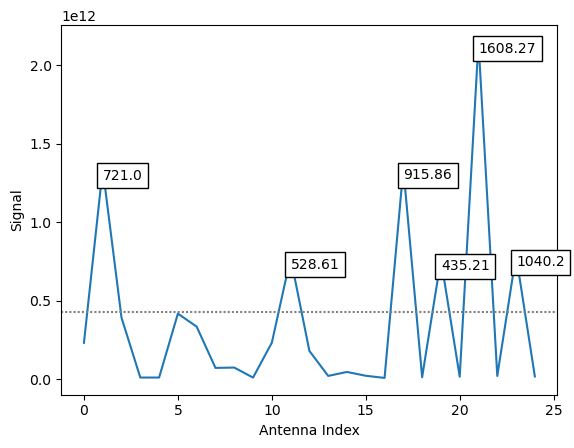

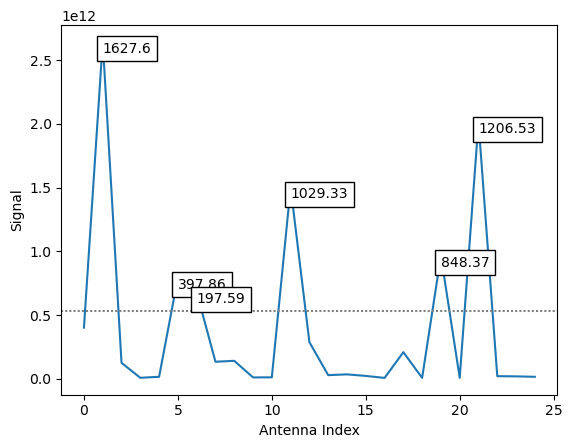

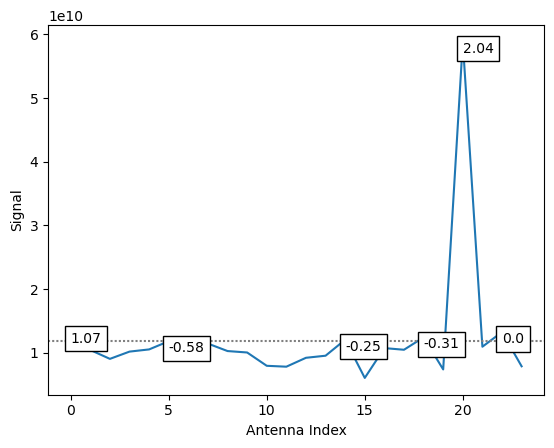

In [81]:
for i, row in weird_ones.iterrows():
    plt.plot(row.antenna_signals)
    plt.scatter(row.anomalous_antennas, row.antenna_signals[row.anomalous_antennas], marker='o', color='red')
    plt.axhline(max(row.antenna_signals) / threshold, dashes=[1, 1, 1, 1], color='gray')
    for antenna in row.anomalous_antennas:
        plt.text(antenna, row.antenna_signals[antenna], round(row.antenna_snrs[antenna], 2), horizontalalignment='left', verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black'))
    plt.xlabel("Antenna Index")
    plt.ylabel("Signal")
    plt.show()

#### Algorithm 2 - std dev above median

Algorithm definitely isn't perfect. Maybe using some std dev above the median would be better

In [95]:
# Returns a list of anomalous antennas or an empty list if none are found
# antenna_signals is (num_antennas, 1) array of the strength of the signal in the antenna
# antenna_snrs is a (num_anennas, 1) array of the snr of the signal in the antenna
# std_dev_threshold is how many standard deviations a signal has to be from the median
# to be an anomalous antenna
# n_anomalous_antennas is the number of anomalous antennas to look for. If it's greater than 1, it's the
# number of antennas which can be above the threshold before it's not an anomalous signal
def find_anomalous_antenna(antenna_signals, antenna_snrs, std_dev_threshold, n_anomalous_antennas=1):
    assert(std_dev_threshold > 0)
    assert(len(antenna_signals > 0))
    assert(len(antenna_snrs > 0))
    assert(n_anomalous_antennas >= 1 and n_anomalous_antennas < 27) # Look for [1, n_antennas - 1] anomalous antennas

    anomalous_antenna_indices = np.where((antenna_signals - np.median(antenna_signals)) > 
                                        (std_dev_threshold * antenna_signals.std()))[0]

    if len(anomalous_antenna_indices) <= n_anomalous_antennas:
        return anomalous_antenna_indices
    else:
        return []

In [144]:
# Go in and get the anomalous antennas out
all_anomalous_antennas = np.full_like(df.id, None, dtype="object")
threshold = 2
for i, row in df.iterrows():
    all_anomalous_antennas[i] = find_anomalous_antenna(row.antenna_signals, row.antenna_snrs, threshold, n_anomalous_antennas=10)

# Save anomalous antennas
df["anomalous_antennas"] = all_anomalous_antennas

# Calculate number of them and save that too
num_anomalous_antennas = [len(antennas) for antennas in all_anomalous_antennas]
df["num_anomalous_antennas"] = num_anomalous_antennas

Text(0, 0.5, 'Count of Hits with That Many Anomalous Antennas')

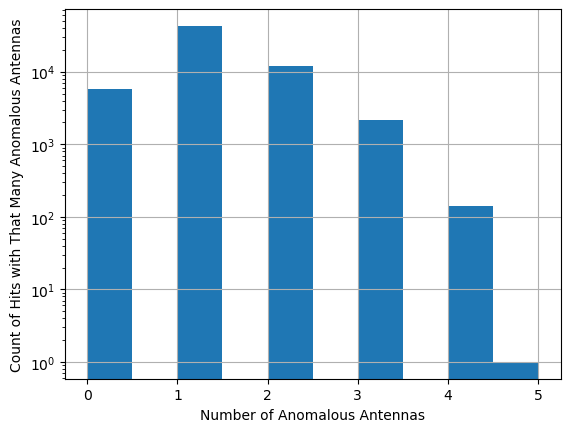

In [145]:
# Look at count of how many anomalous antennas are seen
# Expect to see mostly SARFI (single antenna)
df.num_anomalous_antennas.hist()
plt.yscale('log')
plt.xlabel("Number of Anomalous Antennas")
plt.ylabel("Count of Hits with That Many Anomalous Antennas")

In [148]:
weird_ones = df[df.num_anomalous_antennas > 2]
weird_ones = weird_ones[weird_ones.signal_snr > 12]
print(len(weird_ones))

7


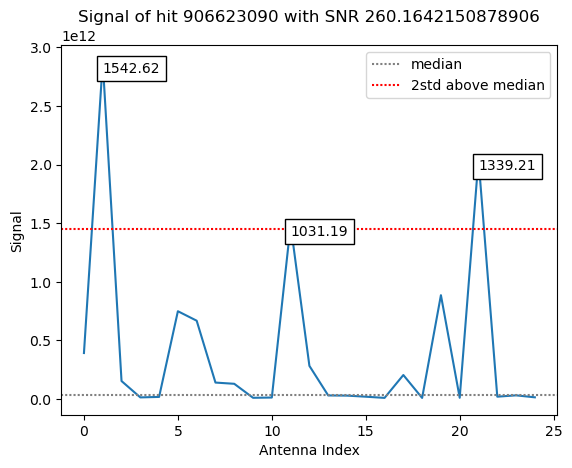

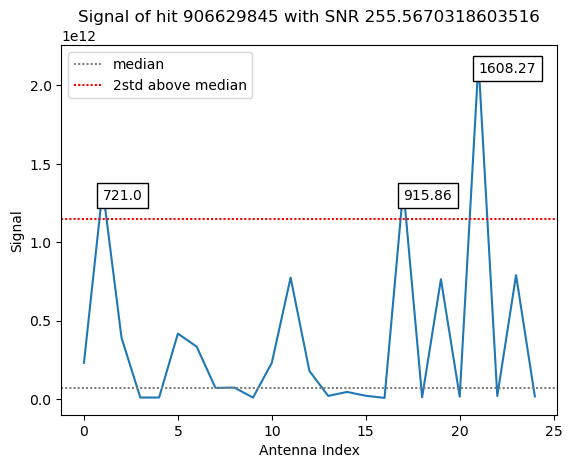

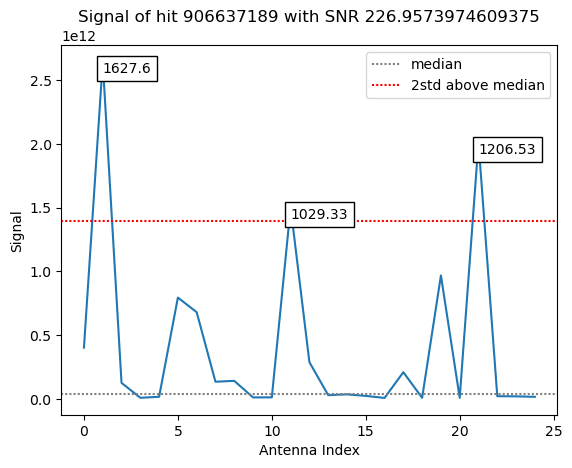

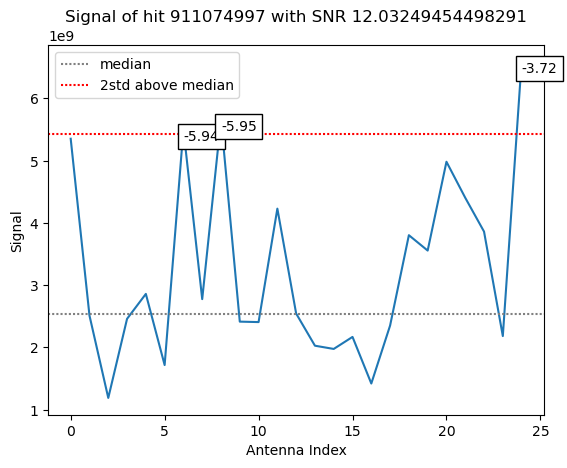

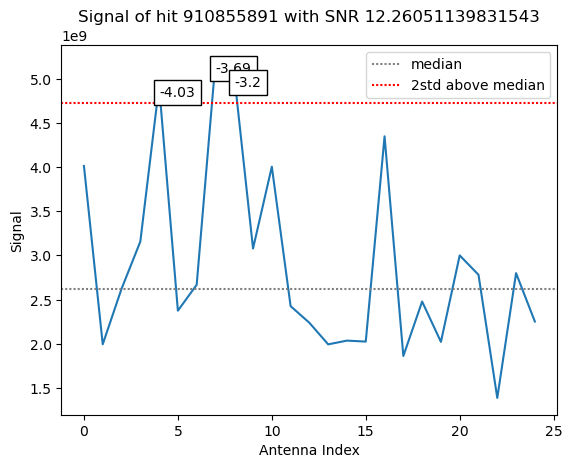

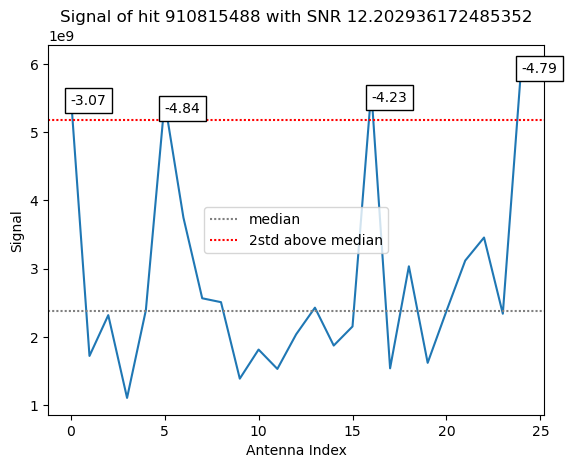

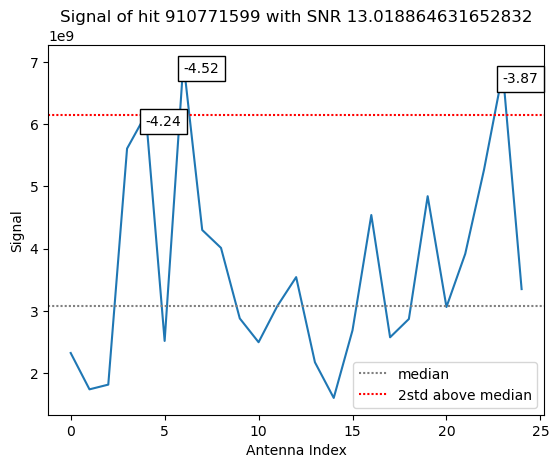

In [149]:
for i, row in weird_ones.iterrows():
    plt.plot(row.antenna_signals)
    plt.scatter(row.anomalous_antennas, row.antenna_signals[row.anomalous_antennas], marker='o', color='red')
    plt.axhline(np.median(row.antenna_signals), dashes=[1, 1, 1, 1], color='gray', label="median")
    plt.axhline(np.median(row.antenna_signals) + threshold * row.antenna_signals.std(), dashes=[1, 1, 1, 1], color='red', label=f"{threshold}std above median")
    for antenna in row.anomalous_antennas:
        plt.text(antenna, row.antenna_signals[antenna], round(row.antenna_snrs[antenna], 2), horizontalalignment='left', verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black'))
    plt.title(f"Signal of hit {row.id} with SNR {row.signal_snr}")
    plt.xlabel("Antenna Index")
    plt.ylabel("Signal")
    plt.legend()
    plt.show()

#### Algorithm 3 - snrs > some cutoff

Unfortunately, SNR is kind of a flaky calculation in seticore so we can't trust it too much

In [5]:
# Threshold is how much stronger the max signal has to be than the next highest signal 
# to be an anomalous antenna


# Returns a list of anomalous antennas or an empty list if none are found
# antenna_signals is (num_antennas, 1) array of the strength of the signal in the antenna
# antenna_snrs is a (num_anennas, 1) array of the snr of the signal in the antenna
# snr_cutoff is how high an snr a signal has to have to be flagged as a genuine signal
# snr_threshold is how much stronger the max signal has to be than another signal to disqualify it from being
# an antenna with a signal in it
# n_anomalous_antennas is the number of antennas with signals to look for. If it's greater than 1, it's the
# number of antennas which can be above the threshold before it's not an anomalous signal
def find_anomalous_antenna(antenna_signals, antenna_snrs, snr_cutoff, snr_threshold, n_anomalous_antennas=1):
    assert(snr_cutoff > 1) # SNR of 1 means signal == noise
    assert(len(antenna_signals > 0))
    assert(len(antenna_snrs > 0))
    assert(n_anomalous_antennas >= 1 and n_anomalous_antennas < 27) # Look for [1, n_antennas - 1] anomalous antennas

    anomalous_antenna_indices = np.where((antenna_snrs > snr_cutoff) * (antenna_snrs > max(antenna_snrs) / snr_threshold))[0]

    if len(anomalous_antenna_indices) <= n_anomalous_antennas:
        return anomalous_antenna_indices
    else:
        return []

In [6]:
# Go in and get the anomalous antennas out
all_anomalous_antennas = np.full_like(df.id, None, dtype="object")
snr_cutoff = 6
snr_threshold = 1000000
for i, row in df.iterrows():
    all_anomalous_antennas[i] = find_anomalous_antenna(row.antenna_signals, row.antenna_snrs, snr_cutoff, snr_threshold, n_anomalous_antennas=10)

# Save anomalous antennas
df["anomalous_antennas"] = all_anomalous_antennas

# Calculate number of them and save that too
num_anomalous_antennas = [len(antennas) for antennas in all_anomalous_antennas]
df["num_anomalous_antennas"] = num_anomalous_antennas

Text(0, 0.5, 'Count of Hits with That Many Anomalous Antennas')

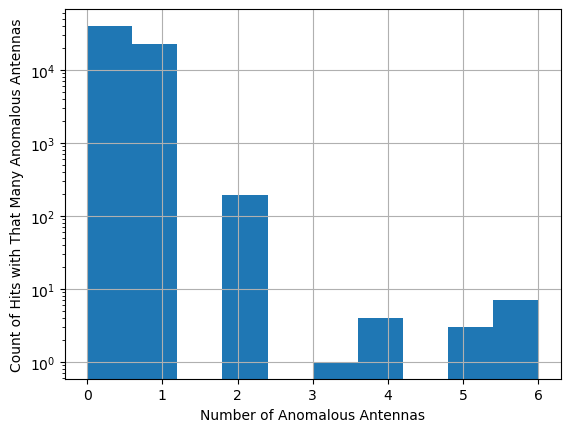

In [7]:
# Look at count of how many anomalous antennas are seen
# Expect to see mostly SARFI (single antenna)
df.num_anomalous_antennas.hist()
plt.yscale('log')
plt.xlabel("Number of Anomalous Antennas")
plt.ylabel("Count of Hits with That Many Anomalous Antennas")

442     900281534
601     900285698
736     900291852
1085    900300372
1369    900305122
1598    900313705
2816    900340482
3024    900346292
3057    900351248
3450    900359227
3821    900370068
4710    900390572
Name: id, dtype: int64

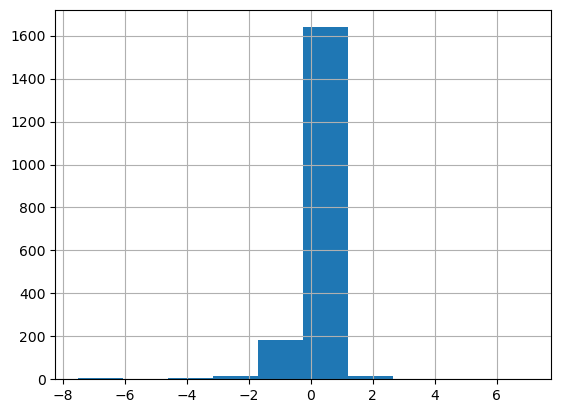

In [18]:
# Look at any SARFI which is drifting and maybe significant?
drifting = df[(abs(df.signal_drift_rate) > 0) * (df.signal_snr > 15)]
drifting.signal_drift_rate.hist()
drifting[abs(drifting.signal_drift_rate) > 3].id

In [8]:
weird_ones = df[df.num_anomalous_antennas > 2]
weird_ones = weird_ones[weird_ones.signal_snr > 12]
print(len(weird_ones))

11


In [9]:
def show_row(row):
    fig, ax1 = plt.subplots()
    ax1.plot(row.antenna_signals, color='blue')
    ax1.scatter(row.anomalous_antennas, row.antenna_signals[row.anomalous_antennas], marker='o', color='red')
    for antenna in row.anomalous_antennas:
        ax1.text(antenna, row.antenna_signals[antenna], round(row.antenna_snrs[antenna], 2), horizontalalignment='left', verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black'))
        
    ax1.set_xlabel("Antenna Index")
    ax1.set_ylabel("Signal", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')


    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(row.antenna_snrs, color='r')
    ax2.set_ylabel('SNR', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.axhline(snr_cutoff, dashes=[1, 1, 1, 1], color='gray', label='cutoff')
    ax2.axhline(max(row.antenna_snrs) / snr_threshold, dashes=[1, 1, 1, 1], color='red', label="threshold")


    plt.title(f"Signal of hit {row.id} with SNR {row.signal_snr}")
    plt.legend()
    plt.show()

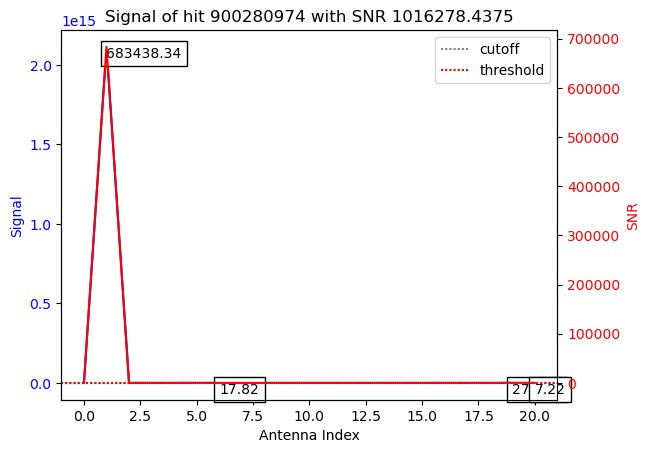

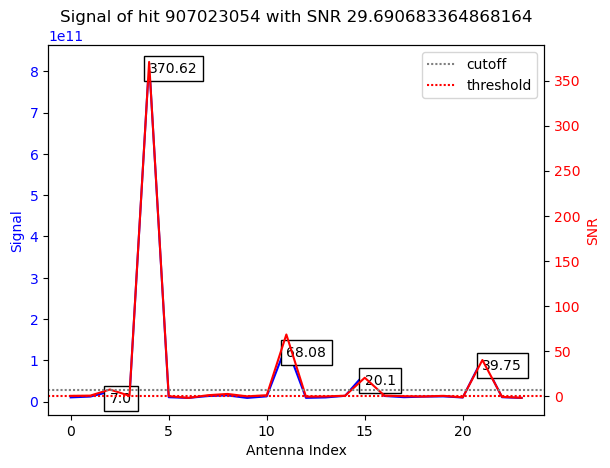

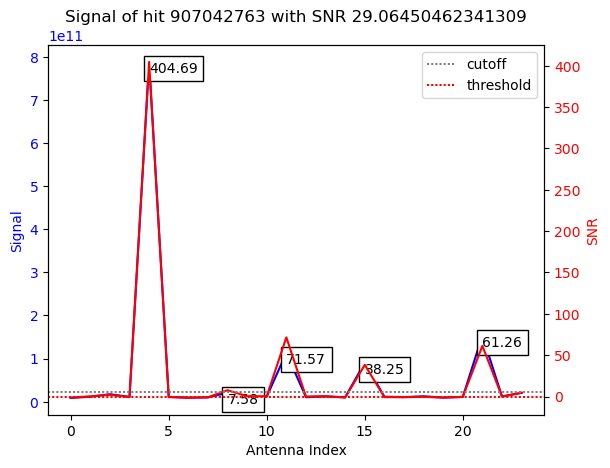

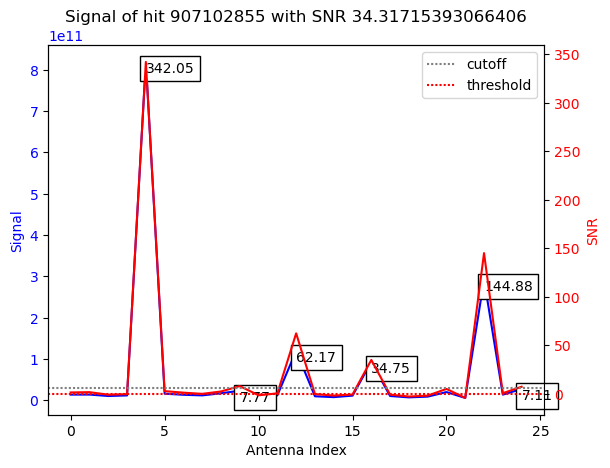

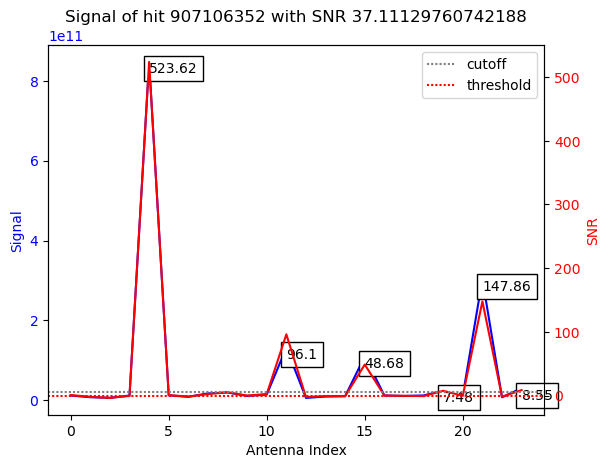

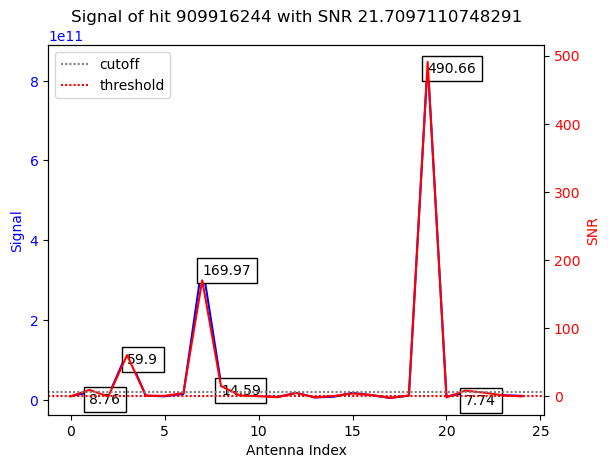

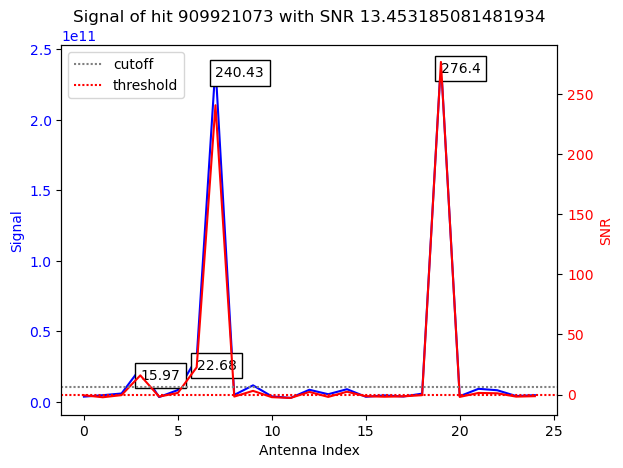

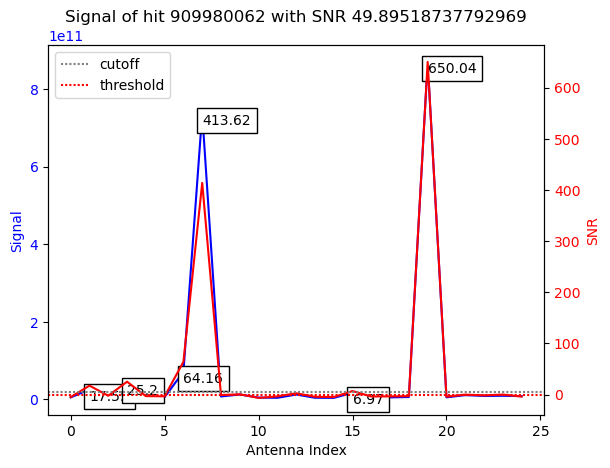

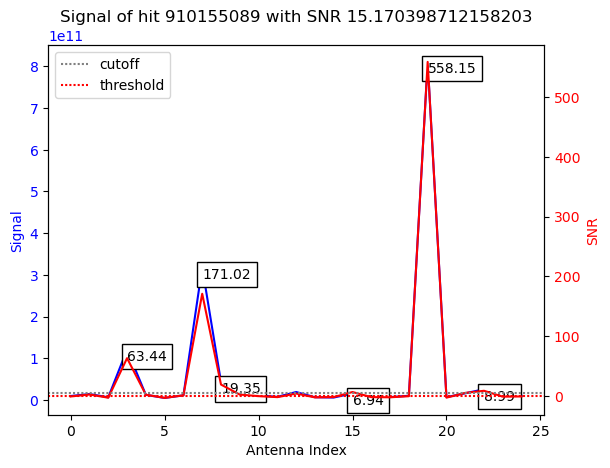

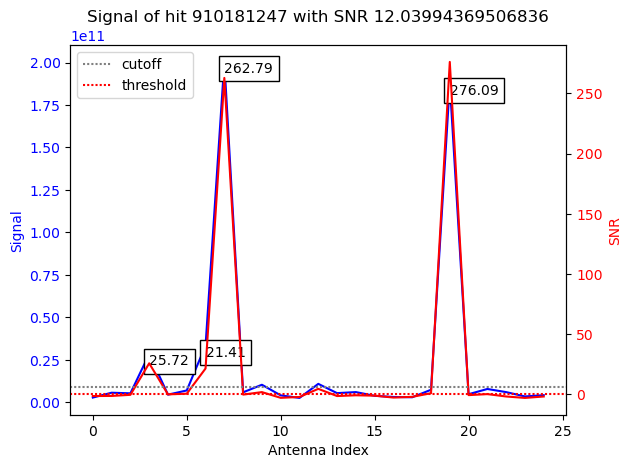

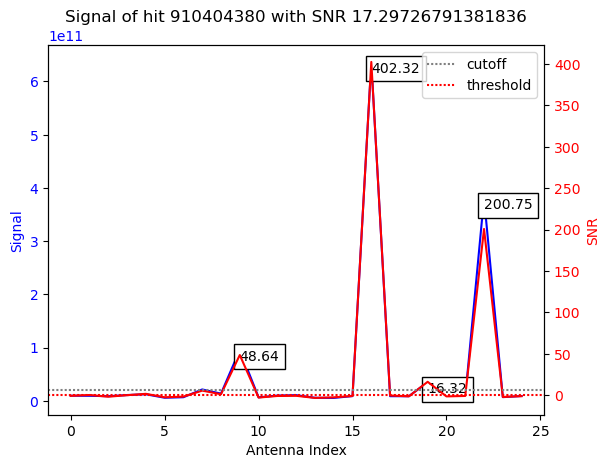

In [10]:
for i, row in weird_ones.iterrows():
    show_row(row)

This is one a previous round said was SARFI. However, I looked at the stamp in look_at_individual_sarfi.ipynb and found that more than half the antennas were looking at it, so it shouldn't be classified as SARFI

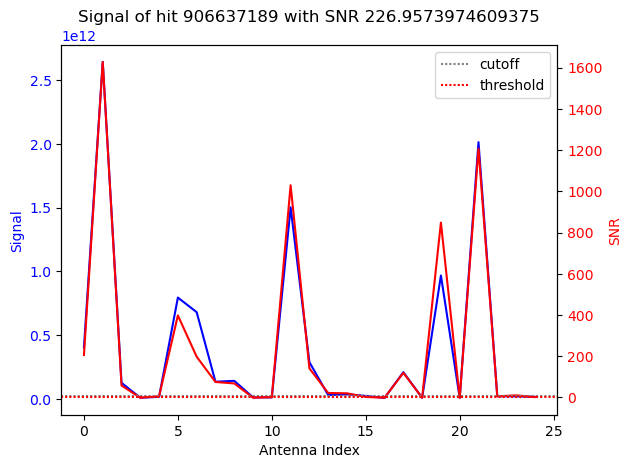

In [11]:
# Let's see how we're doing on one we didn't do super well on before
id = 906637189
to_look_at = df[df.id == id].iloc[0]
show_row(to_look_at)

In [12]:
print(to_look_at.anomalous_antennas)

[]


In [13]:
found = set(to_look_at.anomalous_antennas)
by_eye_SARFI_antennas = set([0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24])
by_eye_SARFI_antennas - found

{0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24}

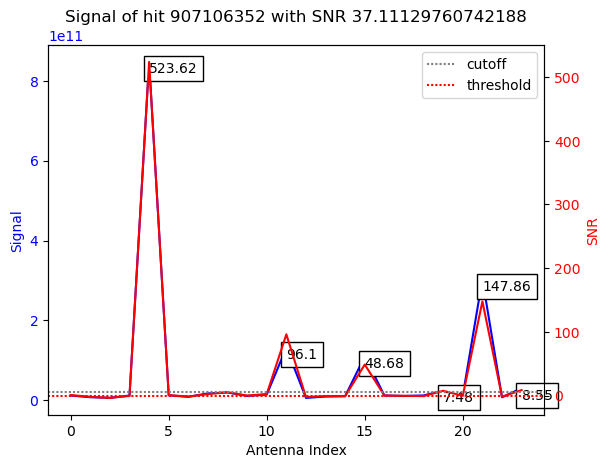

{2}

In [14]:
# Check another one
id = 907106352
to_look_at = df[df.id == id].iloc[0]
show_row(to_look_at)
by_eye = set([2, 4, 11, 15, 21])
found = set(to_look_at.anomalous_antennas)
by_eye - found

##### So let's look at the coherent / incoherent for ones we've identified as SARFI vs. not

In [22]:
sarfi = df[df.num_anomalous_antennas == 1].copy()
print(f"{len(sarfi)} signals have just 1 anomalous antenna")
sarfi['ratio'] = sarfi.signal_power / sarfi.signal_incoherent_power

22677 signals have just 1 anomalous antenna


Text(0.5, 0, 'Coherent Power / Incoherent Power')

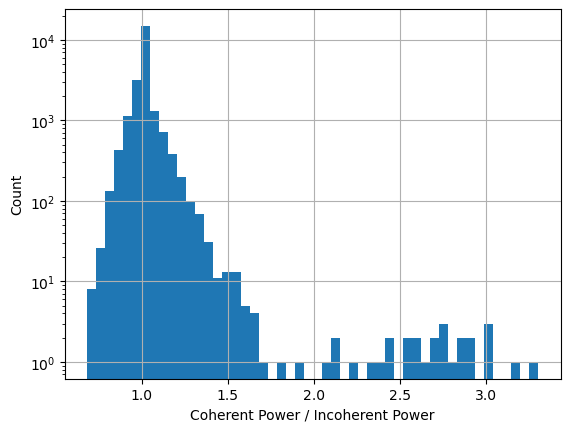

In [26]:
sarfi['ratio'].hist(bins=50)
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Coherent Power / Incoherent Power")

In [29]:
weird_ones = sarfi[sarfi['ratio'] > 1.75]
weird_ones = weird_ones[weird_ones.signal_snr > 12]
print(len(weird_ones))

0


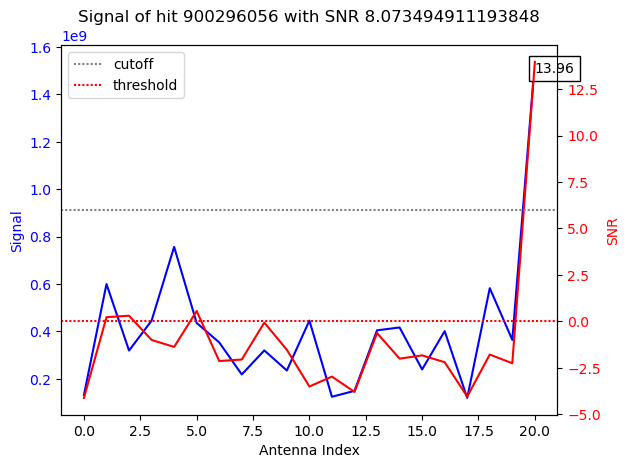

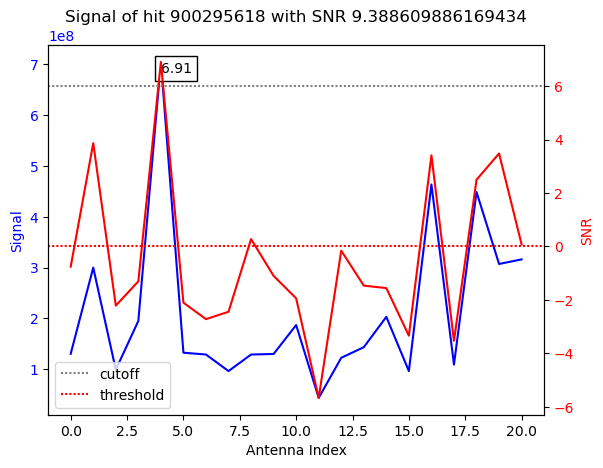

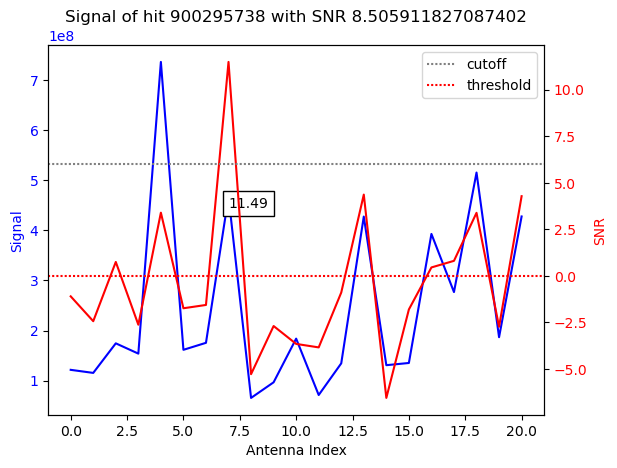

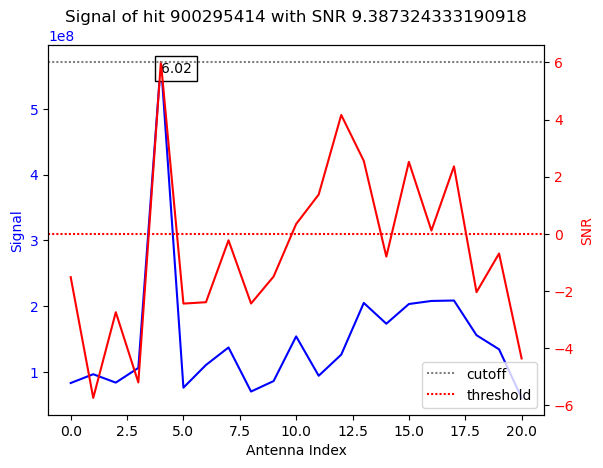

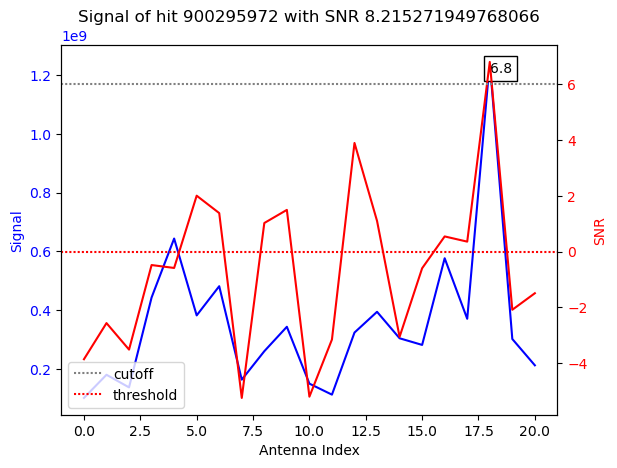

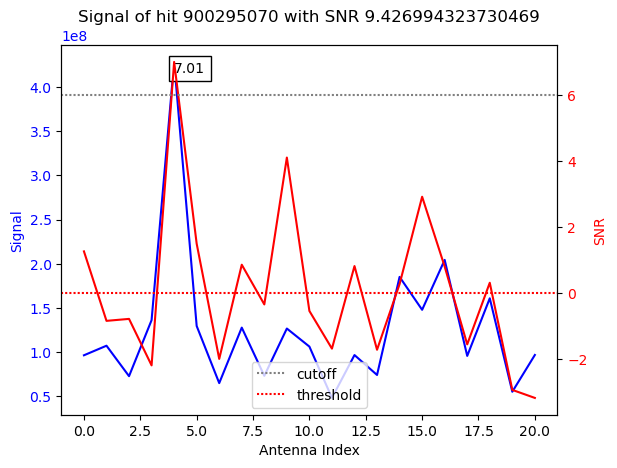

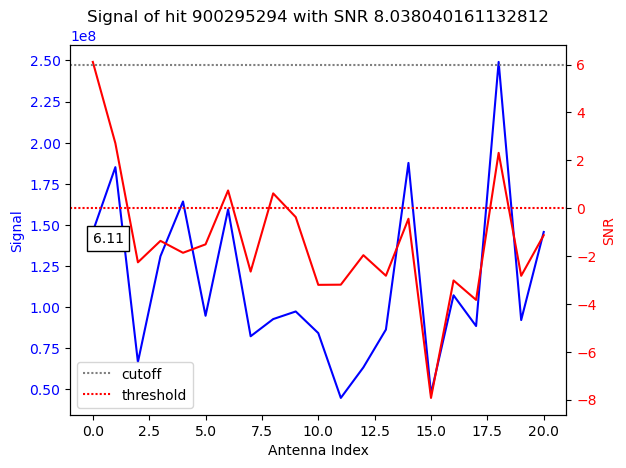

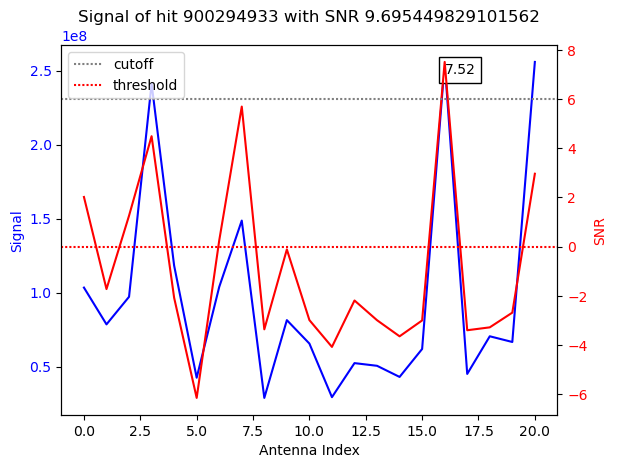

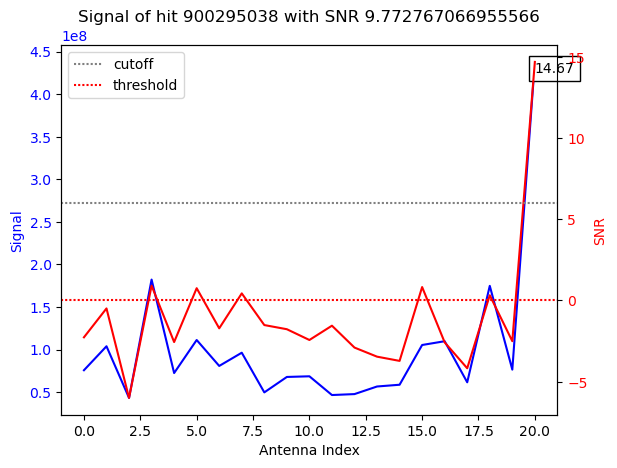

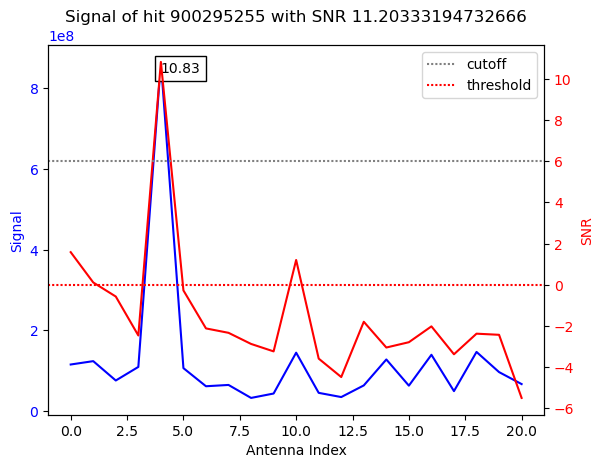

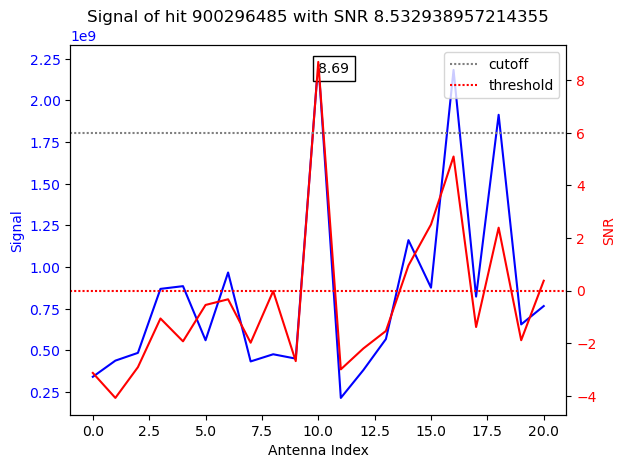

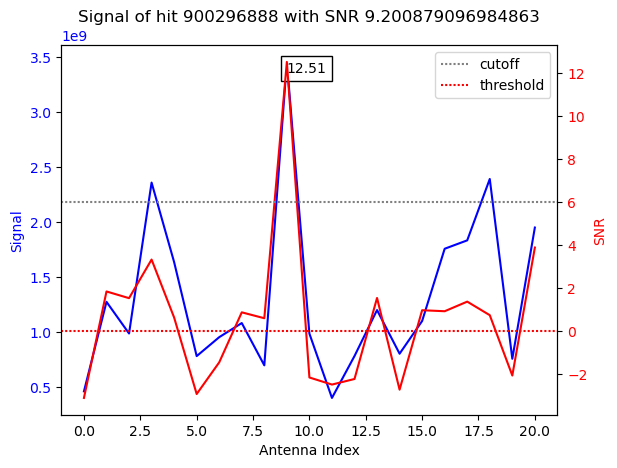

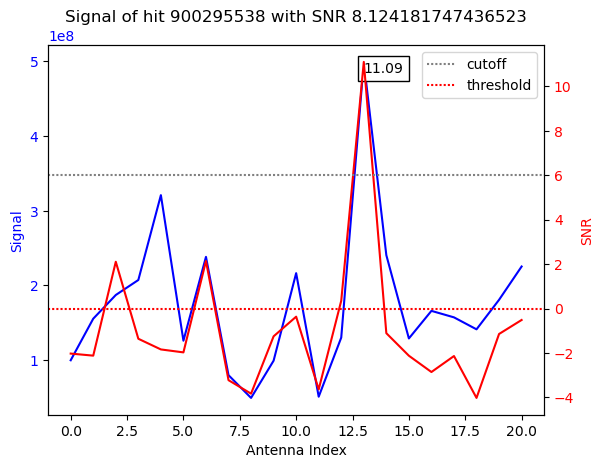

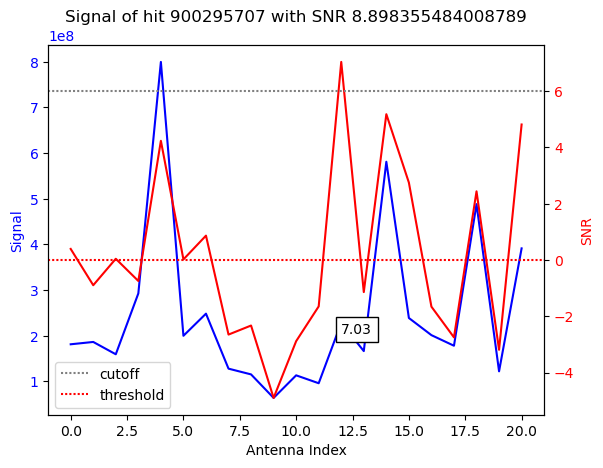

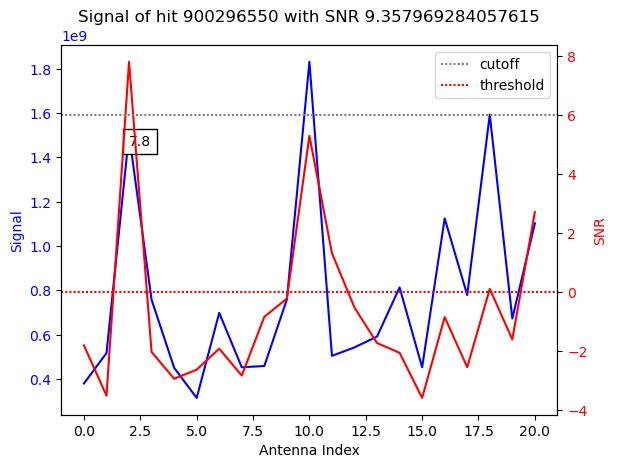

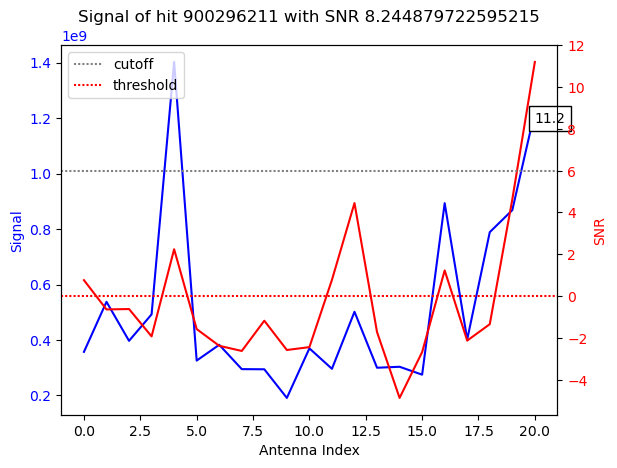

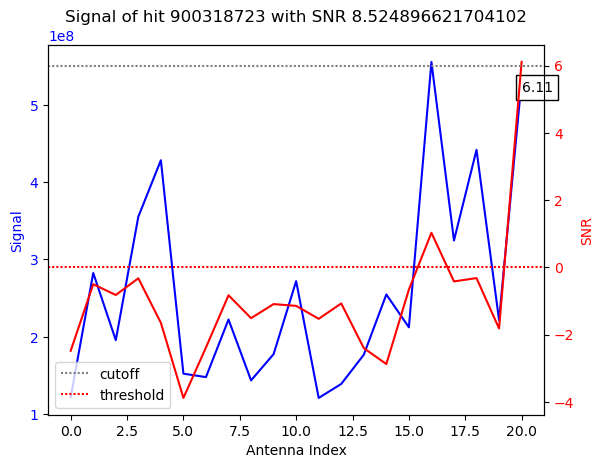

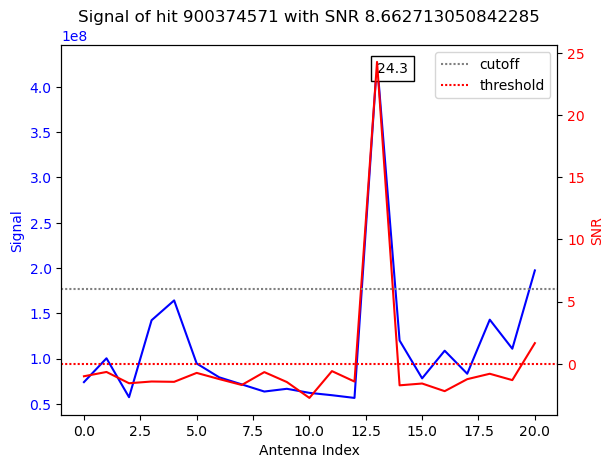

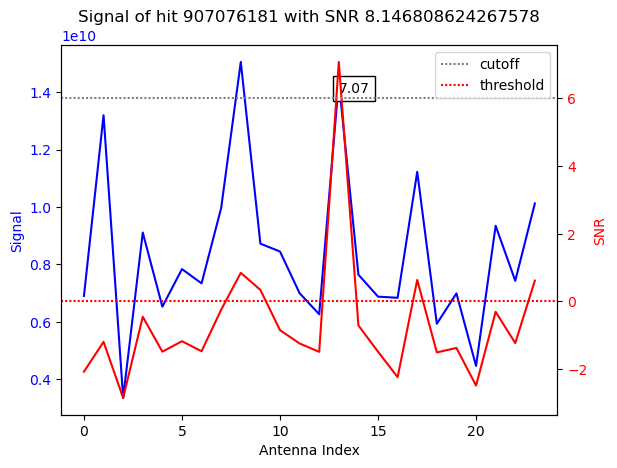

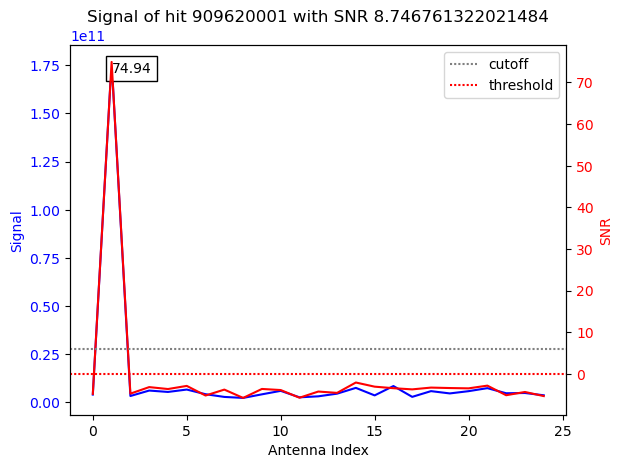

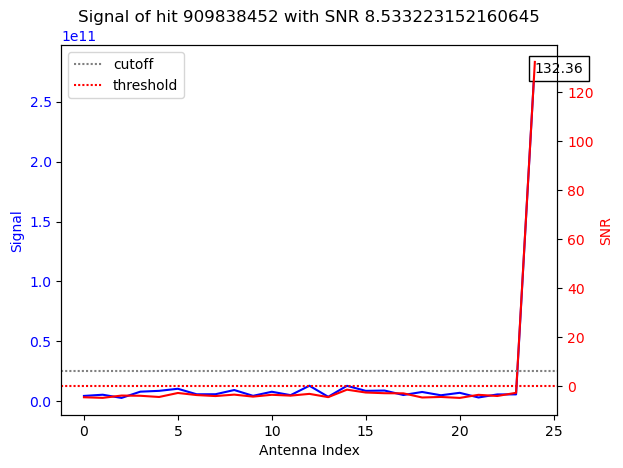

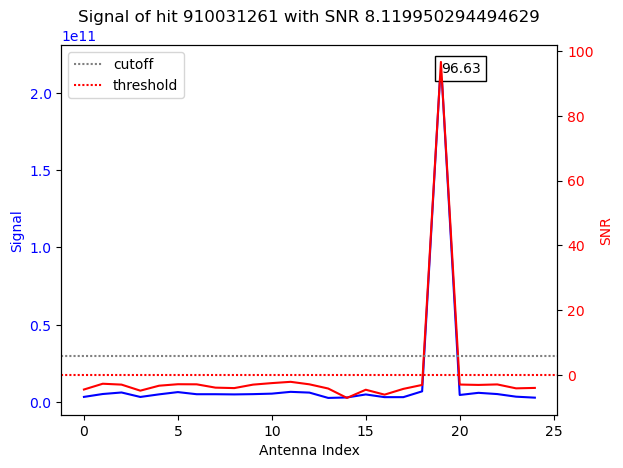

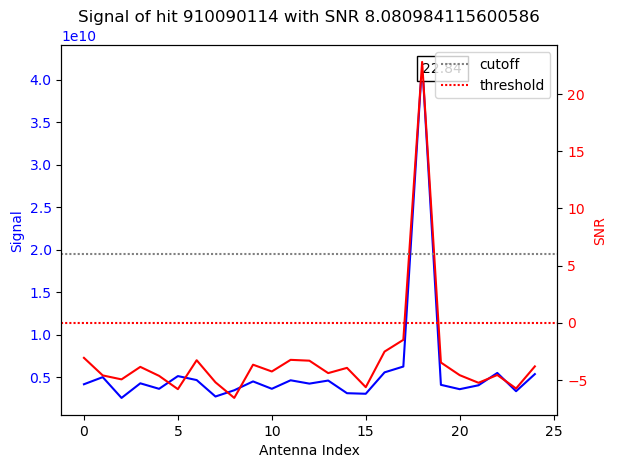

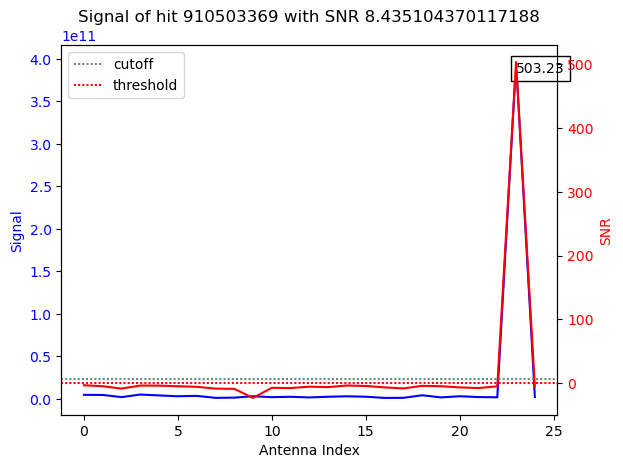

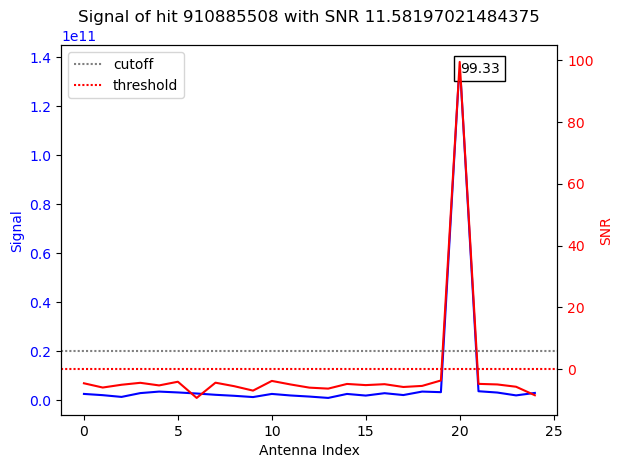

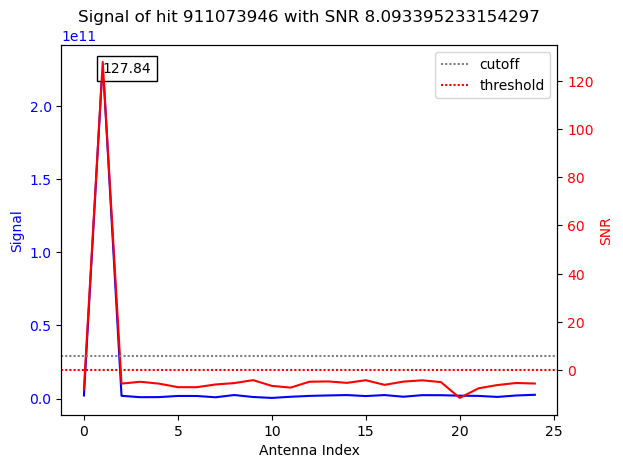

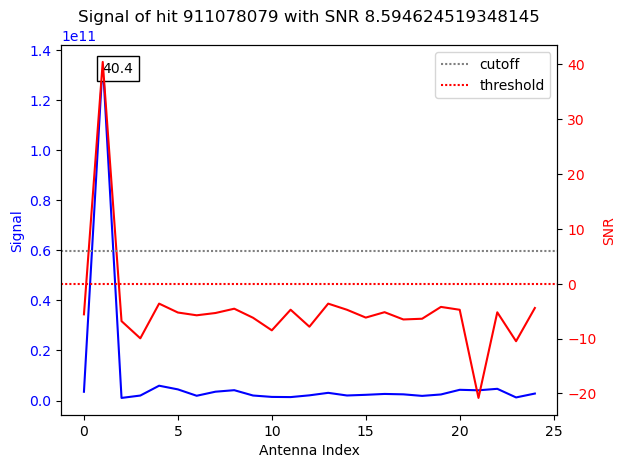

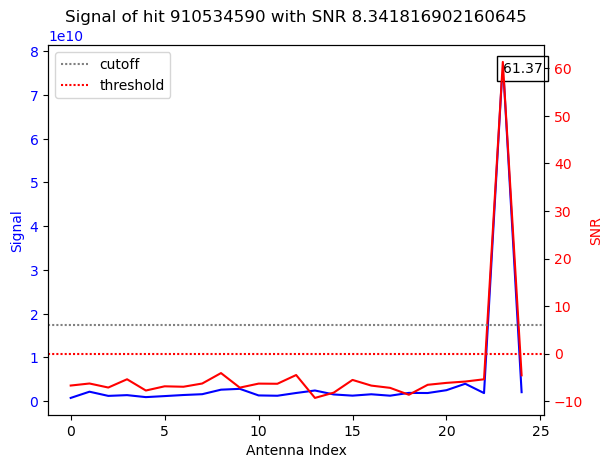

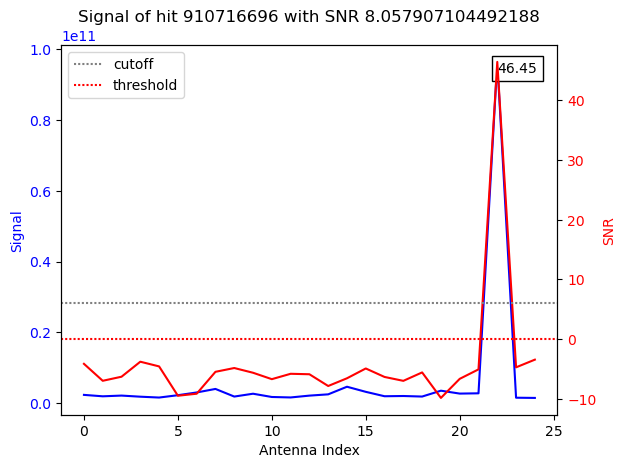

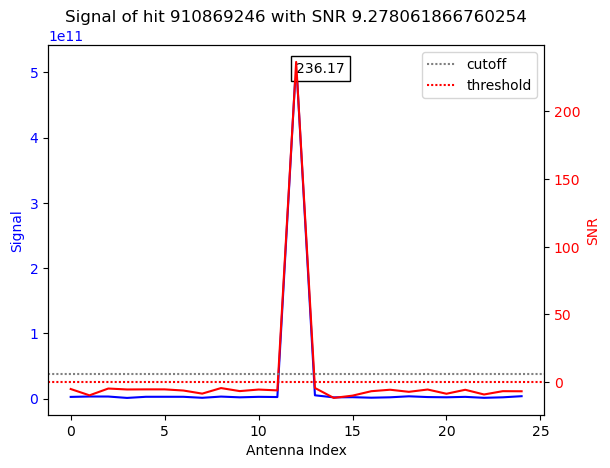

In [28]:
for i, row in weird_ones.iterrows():
    show_row(row)